In [25]:
# This code is to represent our experiments with development set and hypertuning

In [26]:
# Import main Dataset
import pandas as pd
eb = pd.read_csv("emobank.csv", index_col=0 ,engine='python')


In [27]:
# Basic EDA
# Reset default index
eb.reset_index(drop=True, inplace=True)

# Going to use our own split
eb = eb.drop(labels='split', axis=1)

In [28]:
# Extract VAD values
y_V = eb['V']
y_A = eb['A']
y_D = eb['D']

In [29]:
# Feature extraction function that I have decided to use after some experiments

# Preprocessing function with Tf-idf
# Based on code from:
# https://developers.google.com/machine-learning/guides/text-classification/step-3
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts. This way no leaking of information is done.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

In [30]:
# Text to a list for cleaning
eb_list = eb['text'].values.tolist()

In [31]:
# Based on https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90

# Add do not
# Data cleaning function
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
import re
i=0
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))
def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'html.parser')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    i=0
    lower_case=""
    for n in letters_only:
        if i==0:
            if n.isupper() == True :
                i=1
                save = n
            else:
                lower_case += n.lower()
        elif i==1:
            if n.isupper():
                i=2
                lower_case += save
                lower_case += n
            else:
                lower_case += save.lower()
                lower_case += n.lower()
                i=0
        elif i==2:
            lower_case += n
            if n==" ":
                i=0
        else:
            lower_case += n.lower()
            
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()
testing = eb_list
test_result = []
for t in testing:
    test_result.append(tweet_cleaner(t))

c:\users\justs\appdata\local\programs\python\python37\lib\site-packages\bs4\__init__.py:438: MarkupResemblesLocatorWarning: "http://www.law.com/jsp/nlj/PubArticleNLJ.jsp?id=1202463630848&Alcohol_bill_means_happy_hour_for_lobbyists" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning
c:\users\justs\appdata\local\programs\python\python37\lib\site-packages\bs4\__init__.py:343: MarkupResemblesLocatorWarning: "." looks like a directory name, not markup. You may want to open a file found in this directory and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [32]:
# Text for each VAD so it doesnt overlap
eb_list_V = eb_list
eb_list_A = eb_list
eb_list_D = eb_list

In [33]:
# Split Data
from sklearn.model_selection import train_test_split

X_Vtrain, X_Vtest, y_Vtrain, y_Vtest = train_test_split(eb_list_V, y_V, test_size=0.3)
X_Atrain, X_Atest, y_Atrain, y_Atest = train_test_split(eb_list_A, y_A, test_size=0.3)
X_Dtrain, X_Dtest, y_Dtrain, y_Dtest = train_test_split(eb_list_D, y_D, test_size=0.3)


In [34]:
# Preprocess the data with feature extraction function
X_Vtrain, X_Vtest = ngram_vectorize(X_Vtrain, y_Vtrain, X_Vtest)
X_Atrain, X_Atest = ngram_vectorize(X_Atrain, y_Atrain, X_Atest)
X_Dtrain, X_Dtest = ngram_vectorize(X_Dtrain, y_Dtrain, X_Dtest)

In [35]:
# Split into dev set from training set so we get the same distribution
X_Vtest, X_Vdev, y_Vtest, y_Vdev = train_test_split(X_Vtest, y_Vtest, test_size=0.5)
X_Atest, X_Adev, y_Atest, y_Adev = train_test_split(X_Atest, y_Atest, test_size=0.5)
X_Dtest, X_Ddev, y_Dtest, y_Ddev = train_test_split(X_Dtest, y_Dtest, test_size=0.5)

In [36]:
# Model training
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

clf4 = Ridge()
clf5 = Ridge()
clf6 = Ridge()

clf4 = clf4.fit(X_Vtrain, y_Vtrain) 
clf5 = clf5.fit(X_Atrain, y_Atrain)
clf6 = clf6.fit(X_Dtrain, y_Dtrain) 

print("TEST DATASET")
rslt_V_R = clf4.predict(X_Vtest)
print('V - Ridge')
print(rslt_V_R)
rslt_A_R = clf5.predict(X_Atest)
print('A - Ridge')
print(rslt_A_R)
rslt_D_R = clf6.predict(X_Dtest)
print('D - Ridge')
print(rslt_D_R)

print("DEV DATASET")
rslt_dev_V_R = clf4.predict(X_Vdev)
print('V - Ridge')
print(rslt_dev_V_R)
rslt_dev_A_R = clf5.predict(X_Adev)
print('A - Ridge')
print(rslt_dev_A_R)
rslt_dev_D_R = clf6.predict(X_Ddev)
print('D - Ridge')
print(rslt_dev_D_R)

print("TRAIN DATASET")
rslt_train_V_R = clf4.predict(X_Vtrain)
print('V - Ridge')
print(rslt_train_V_R)
rslt_train_A_R = clf5.predict(X_Atrain)
print('A - Ridge')
print(rslt_train_A_R)
rslt_train_D_R = clf6.predict(X_Dtrain)
print('D - Ridge')
print(rslt_train_D_R)

TEST DATASET
V - Ridge
[3.008872  3.0072367 3.07831   ... 2.8582947 3.2117534 2.7310483]
A - Ridge
[3.058303  3.2923105 2.827989  ... 3.0291662 3.205193  2.9711533]
D - Ridge
[3.111004  3.0763285 2.9104254 ... 3.1220136 3.1527054 3.1783786]
DEV DATASET
V - Ridge
[3.9922242 2.9835162 3.1539302 ... 3.1176324 2.6661518 2.8659594]
A - Ridge
[2.920044  3.1145248 3.0467317 ... 2.918341  2.983447  3.225306 ]
D - Ridge
[3.041426  3.0527368 3.0151665 ... 3.0430226 3.2025723 3.028115 ]
TRAIN DATASET
V - Ridge
[2.5531056 3.1921573 2.9652553 ... 3.1116266 2.642628  3.1349244]
A - Ridge
[3.1012564 2.9641135 3.190755  ... 3.0016265 2.9961407 2.9762127]
D - Ridge
[2.9553232 3.1901805 3.0951574 ... 3.0227046 3.0870771 2.8369038]


In [37]:
# Mean squared error - how far observed values differ from predicted mean. Goal: low value
print("Ridge regression - train dataset - mse")
print("Mean squared error for Valance: %.2f" % mean_squared_error(y_Vtrain, rslt_train_V_R))
print("Mean squared error for Arousal: %.2f" % mean_squared_error(y_Atrain, rslt_train_A_R))
print("Mean squared error for Dominance: %.2f" % mean_squared_error(y_Dtrain, rslt_train_D_R))

Ridge regression - train dataset - mse
Mean squared error for Valance: 0.03
Mean squared error for Arousal: 0.02
Mean squared error for Dominance: 0.02


In [38]:
print("Ridge regression - dev dataset - mse")
print("Mean squared error for Valance: %.2f" % mean_squared_error(y_Vdev, rslt_dev_V_R))
print("Mean squared error for Arousal: %.2f" % mean_squared_error(y_Adev, rslt_dev_A_R))
print("Mean squared error for Dominance: %.2f" % mean_squared_error(y_Ddev, rslt_dev_D_R))

Ridge regression - dev dataset - mse
Mean squared error for Valance: 0.08
Mean squared error for Arousal: 0.05
Mean squared error for Dominance: 0.04


In [39]:
print("Ridge regression - test dataset - mse")
print("Mean squared error for Valance: %.2f" % mean_squared_error(y_Vtest, rslt_V_R))
print("Mean squared error for Arousal: %.2f" % mean_squared_error(y_Atest, rslt_A_R))
print("Mean squared error for Dominance: %.2f" % mean_squared_error(y_Dtest, rslt_D_R))

Ridge regression - test dataset - mse
Mean squared error for Valance: 0.08
Mean squared error for Arousal: 0.07
Mean squared error for Dominance: 0.04


In [40]:
# How big an we can expect
print("Ridge regression - train dataset - mae")
print("mae for Valance: %.2f" % mean_absolute_error(y_Vtrain, rslt_train_V_R))
print("mae for Arousal: %.2f" % mean_absolute_error(y_Atrain, rslt_train_A_R))
print("mae for Dominance: %.2f" % mean_absolute_error(y_Dtrain, rslt_train_D_R))

Ridge regression - train dataset - mae
mae for Valance: 0.13
mae for Arousal: 0.12
mae for Dominance: 0.10


In [41]:
# R2 the higher the score the bigger the correlation. R2 diagrams below
print("Ridge regression - train dataset - r2")
print("r2 for Valance: %.2f" % r2_score(y_Vtrain, rslt_train_V_R))
print("r2 for Arousal: %.2f" % r2_score(y_Atrain, rslt_train_A_R))
print("r2 for Dominance: %.2f" % r2_score(y_Dtrain, rslt_train_D_R))


Ridge regression - train dataset - r2
r2 for Valance: 0.73
r2 for Arousal: 0.64
r2 for Dominance: 0.62


In [42]:
print("Ridge regression - test dataset - mae")
print("mae for Valance: %.2f" % mean_absolute_error(y_Vtest, rslt_V_R))
print("mae for Arousal: %.2f" % mean_absolute_error(y_Atest, rslt_A_R))
print("mae for Dominance: %.2f" % mean_absolute_error(y_Dtest, rslt_D_R))

Ridge regression - test dataset - mae
mae for Valance: 0.21
mae for Arousal: 0.20
mae for Dominance: 0.15


In [43]:
print("Ridge regression - test dataset - r2")
print("r2 Valance: %.2f" % r2_score(y_Vtest, rslt_V_R))
print("r2 for Arousal: %.2f" % r2_score(y_Atest, rslt_A_R))
print("r2 for Dominance: %.2f" % r2_score(y_Dtest, rslt_D_R))


Ridge regression - test dataset - r2
r2 Valance: 0.26
r2 for Arousal: 0.09
r2 for Dominance: 0.02


In [44]:
print("Ridge regression - dev dataset - mae")
print("mae for Valance: %.2f" % mean_absolute_error(y_Vdev, rslt_dev_V_R))
print("mae for Arousal: %.2f" % mean_absolute_error(y_Adev, rslt_dev_A_R))
print("mae for Dominance: %.2f" % mean_absolute_error(y_Ddev, rslt_dev_D_R))

Ridge regression - dev dataset - mae
mae for Valance: 0.21
mae for Arousal: 0.18
mae for Dominance: 0.16


In [45]:
print("Ridge regression - dev dataset - r2")
print("r2 for Valance: %.2f" % r2_score(y_Vdev, rslt_dev_V_R))
print("r2 for Arousal: %.2f" % r2_score(y_Adev, rslt_dev_A_R))
print("r2 for Dominance: %.2f" % r2_score(y_Ddev, rslt_dev_D_R))


Ridge regression - dev dataset - r2
r2 for Valance: 0.32
r2 for Arousal: 0.08
r2 for Dominance: 0.03


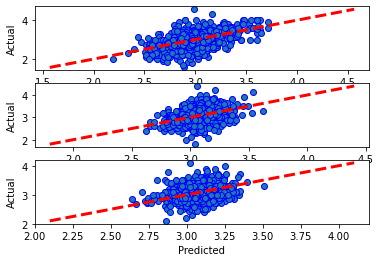

In [46]:
import matplotlib.pyplot as plt
fig, (ax1,ax2,ax3) = plt.subplots(nrows = 3, ncols = 1)
ax1.scatter(rslt_V_R, y_Vtest, edgecolors=(0, 0, 1))
ax1.plot([y_Vtest.min(), y_Vtest.max()], [y_Vtest.min(), y_Vtest.max()], 'r--', lw=3)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax2.scatter(rslt_A_R, y_Atest, edgecolors=(0,0,1))
ax2.plot([y_Atest.min(), y_Atest.max()], [y_Atest.min(), y_Atest.max()], 'r--', lw=3)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax3.scatter(rslt_D_R, y_Dtest, edgecolors=(0,0,1))
ax3.plot([y_Dtest.min(), y_Dtest.max()], [y_Dtest.min(), y_Dtest.max()], 'r--', lw=3)
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')
plt.show()

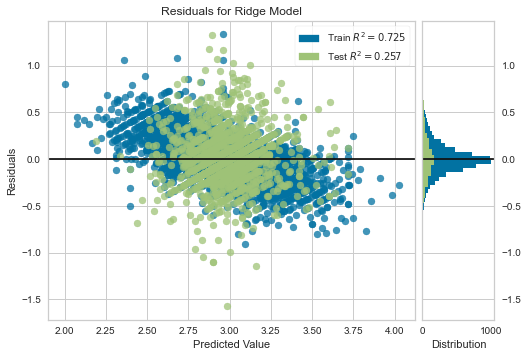

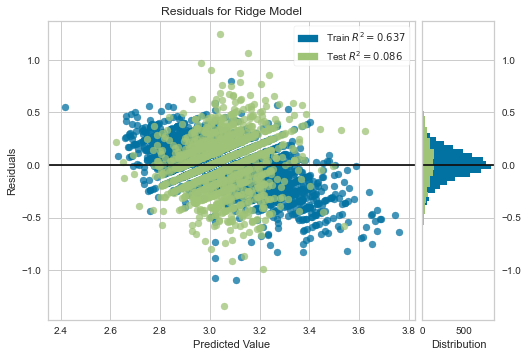

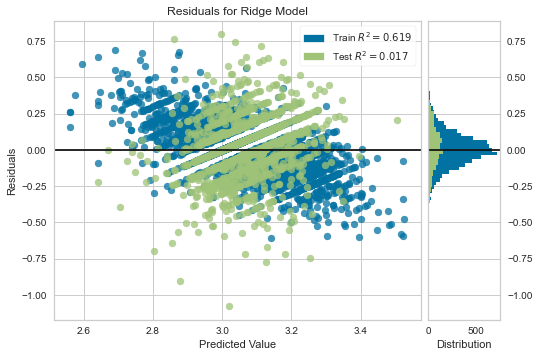

In [47]:
from yellowbrick.regressor import residuals_plot
viz_V = residuals_plot(clf4, X_Vtrain, y_Vtrain, X_Vtest, y_Vtest)
viz_A = residuals_plot(clf5, X_Atrain, y_Atrain, X_Atest, y_Atest)
viz_D = residuals_plot(clf6, X_Dtrain, y_Dtrain, X_Dtest, y_Dtest)

In [48]:
# Evaluation with CV
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

In [49]:
# CV with mse
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score

scores_V = cross_val_score(clf4, X_Vtrain, y_Vtrain, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores_A = cross_val_score(clf5, X_Atrain, y_Atrain, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores_D = cross_val_score(clf6, X_Dtrain, y_Dtrain, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# report performance
print('Valence mse: %.3f (%.3f)' % (mean(scores_V), std(scores_V)))
print('Arousal mse: %.3f (%.3f)' % (mean(scores_A), std(scores_A)))
print('Dominance mse: %.3f (%.3f)' % (mean(scores_D), std(scores_D)))

Valence mse: -0.091 (0.005)
Arousal mse: -0.063 (0.002)
Dominance mse: -0.043 (0.002)


In [50]:
scores_V = cross_val_score(clf4, X_Vdev, y_Vdev, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores_A = cross_val_score(clf5, X_Adev, y_Adev, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores_D = cross_val_score(clf6, X_Ddev, y_Ddev, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# report performance
print('Valence mse: %.3f (%.3f)' % (mean(scores_V), std(scores_V)))
print('Arousal mse: %.3f (%.3f)' % (mean(scores_A), std(scores_A)))
print('Dominance mse: %.3f (%.3f)' % (mean(scores_D), std(scores_D)))

Valence mse: -0.100 (0.010)
Arousal mse: -0.055 (0.004)
Dominance mse: -0.044 (0.004)


In [51]:
scores_V = cross_val_score(clf4, X_Vtest, y_Vtest, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores_A = cross_val_score(clf5, X_Atest, y_Atest, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores_D = cross_val_score(clf6, X_Dtest, y_Dtest, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# report performance
print('Valence mse: %.3f (%.3f)' % (mean(scores_V), std(scores_V)))
print('Arousal mse: %.3f (%.3f)' % (mean(scores_A), std(scores_A)))
print('Dominance mse: %.3f (%.3f)' % (mean(scores_D), std(scores_D)))

Valence mse: -0.101 (0.010)
Arousal mse: -0.071 (0.007)
Dominance mse: -0.041 (0.003)


In [52]:
# CV with mae
scores_V = cross_val_score(clf4, X_Vtrain, y_Vtrain, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_A = cross_val_score(clf5, X_Atrain, y_Atrain, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_D = cross_val_score(clf6, X_Dtrain, y_Dtrain, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# report performance
print('Valence mse: %.3f (%.3f)' % (mean(scores_V), std(scores_V)))
print('Arousal mse: %.3f (%.3f)' % (mean(scores_A), std(scores_A)))
print('Dominance mse: %.3f (%.3f)' % (mean(scores_D), std(scores_D)))

Valence mse: -0.215 (0.006)
Arousal mse: -0.189 (0.003)
Dominance mse: -0.156 (0.003)


In [53]:
scores_V = cross_val_score(clf4, X_Vdev, y_Vdev, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_A = cross_val_score(clf5, X_Adev, y_Adev, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_D = cross_val_score(clf6, X_Ddev, y_Ddev, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# report performance
print('Valence mse: %.3f (%.3f)' % (mean(scores_V), std(scores_V)))
print('Arousal mse: %.3f (%.3f)' % (mean(scores_A), std(scores_A)))
print('Dominance mse: %.3f (%.3f)' % (mean(scores_D), std(scores_D)))

Valence mse: -0.227 (0.014)
Arousal mse: -0.181 (0.006)
Dominance mse: -0.156 (0.005)


In [54]:
scores_V = cross_val_score(clf4, X_Vtest, y_Vtest, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_A = cross_val_score(clf5, X_Atest, y_Atest, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_D = cross_val_score(clf6, X_Dtest, y_Dtest, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# report performance
print('Valence mse: %.3f (%.3f)' % (mean(scores_V), std(scores_V)))
print('Arousal mse: %.3f (%.3f)' % (mean(scores_A), std(scores_A)))
print('Dominance mse: %.3f (%.3f)' % (mean(scores_D), std(scores_D)))

Valence mse: -0.227 (0.011)
Arousal mse: -0.201 (0.008)
Dominance mse: -0.151 (0.006)


In [55]:
# CV with mae
scores_V = cross_val_score(clf4, X_Vtrain, y_Vtrain, scoring='r2', cv=cv, n_jobs=-1)
scores_A = cross_val_score(clf5, X_Atrain, y_Atrain, scoring='r2', cv=cv, n_jobs=-1)
scores_D = cross_val_score(clf6, X_Dtrain, y_Dtrain, scoring='r2', cv=cv, n_jobs=-1)
# report performance
print('Valence mse: %.3f (%.3f)' % (mean(scores_V), std(scores_V)))
print('Arousal mse: %.3f (%.3f)' % (mean(scores_A), std(scores_A)))
print('Dominance mse: %.3f (%.3f)' % (mean(scores_D), std(scores_D)))

Valence mse: 0.263 (0.025)
Arousal mse: 0.082 (0.018)
Dominance mse: 0.017 (0.016)


In [56]:
scores_V = cross_val_score(clf4, X_Vdev, y_Vdev, scoring='r2', cv=cv, n_jobs=-1)
scores_A = cross_val_score(clf5, X_Adev, y_Adev, scoring='r2', cv=cv, n_jobs=-1)
scores_D = cross_val_score(clf6, X_Ddev, y_Ddev, scoring='r2', cv=cv, n_jobs=-1)
# report performance
print('Valence r2: %.3f (%.3f)' % (mean(scores_V), std(scores_V)))
print('Arousal r2: %.3f (%.3f)' % (mean(scores_A), std(scores_A)))
print('Dominance r2: %.3f (%.3f)' % (mean(scores_D), std(scores_D)))

Valence r2: 0.150 (0.023)
Arousal r2: 0.046 (0.028)
Dominance r2: 0.003 (0.032)


In [57]:
scores_V = cross_val_score(clf4, X_Vtest, y_Vtest, scoring='r2', cv=cv, n_jobs=-1)
scores_A = cross_val_score(clf5, X_Atest, y_Atest, scoring='r2', cv=cv, n_jobs=-1)
scores_D = cross_val_score(clf6, X_Dtest, y_Dtest, scoring='r2', cv=cv, n_jobs=-1)
# report performance
print('Valence r2: %.3f (%.3f)' % (mean(scores_V), std(scores_V)))
print('Arousal r2: %.3f (%.3f)' % (mean(scores_A), std(scores_A)))
print('Dominance r2: %.3f (%.3f)' % (mean(scores_D), std(scores_D)))

Valence r2: 0.098 (0.022)
Arousal r2: 0.009 (0.032)
Dominance r2: 0.024 (0.026)


In [58]:
#https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/

#from sklearn.model_selection import GridSearchCV
#space = dict()
#space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
#space['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
#space['fit_intercept'] = [True, False]
#space['normalize'] = [True, False]
# define search
#search = GridSearchCV(clf4, space, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)
# execute search
#result = search.fit(X_Vdev, y_Vdev)
# summarize result
#print('Best Score: %s' % result.best_score_)
#print('Best Hyperparameters: %s' % result.best_params_)

In [59]:
# After doing hyper tunning we found that best solver is svd and regulization strength is best at 1, 2.5, 3 respectively# 
# So now I will change the models to be better and evaluate them again

clf4 = Ridge(solver='sag', alpha=1 )
clf5 = Ridge(solver='sag', alpha=2.5 )
clf6 = Ridge(solver='sag', alpha=3 )
clf4 = clf4.fit(X_Vtrain, y_Vtrain) 
clf5 = clf5.fit(X_Atrain, y_Atrain)
clf6 = clf6.fit(X_Dtrain, y_Dtrain) 


c:\users\justs\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:730: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '
c:\users\justs\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:730: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '
c:\users\justs\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:730: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or 

In [60]:

scores_V = cross_val_score(clf4, X_Vtrain, y_Vtrain, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores_A = cross_val_score(clf5, X_Atrain, y_Atrain, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores_D = cross_val_score(clf6, X_Dtrain, y_Dtrain, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# report performance
print('Valence train mse: %.3f (%.3f)' % (mean(scores_V), std(scores_V)))
print('Arousal train mse: %.3f (%.3f)' % (mean(scores_A), std(scores_A)))
print('Dominance train mse: %.3f (%.3f)' % (mean(scores_D), std(scores_D)))
print("")

scores_V = cross_val_score(clf4, X_Vdev, y_Vdev, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores_A = cross_val_score(clf5, X_Adev, y_Adev, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores_D = cross_val_score(clf6, X_Ddev, y_Ddev, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# report performance
print('Valence dev mse: %.3f (%.3f)' % (mean(scores_V), std(scores_V)))
print('Arousal dev mse: %.3f (%.3f)' % (mean(scores_A), std(scores_A)))
print('Dominance dev mse: %.3f (%.3f)' % (mean(scores_D), std(scores_D)))
print("")

scores_V = cross_val_score(clf4, X_Vtest, y_Vtest, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores_A = cross_val_score(clf5, X_Atest, y_Atest, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores_D = cross_val_score(clf6, X_Dtest, y_Dtest, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# report performance
print('Valence test mse: %.3f (%.3f)' % (mean(scores_V), std(scores_V)))
print('Arousal test mse: %.3f (%.3f)' % (mean(scores_A), std(scores_A)))
print('Dominance test mse: %.3f (%.3f)' % (mean(scores_D), std(scores_D)))
print("")

scores_V = cross_val_score(clf4, X_Vtrain, y_Vtrain, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_A = cross_val_score(clf5, X_Atrain, y_Atrain, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_D = cross_val_score(clf6, X_Dtrain, y_Dtrain, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# report performance
print('Valence train mae: %.3f (%.3f)' % (mean(scores_V), std(scores_V)))
print('Arousal train mae: %.3f (%.3f)' % (mean(scores_A), std(scores_A)))
print('Dominance train mae: %.3f (%.3f)' % (mean(scores_D), std(scores_D)))
print("")

scores_V = cross_val_score(clf4, X_Vdev, y_Vdev, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_A = cross_val_score(clf5, X_Adev, y_Adev, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_D = cross_val_score(clf6, X_Ddev, y_Ddev, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# report performance
print('Valence dev mae: %.3f (%.3f)' % (mean(scores_V), std(scores_V)))
print('Arousal dev mae: %.3f (%.3f)' % (mean(scores_A), std(scores_A)))
print('Dominance train mae: %.3f (%.3f)' % (mean(scores_D), std(scores_D)))
print("")

scores_V = cross_val_score(clf4, X_Vtest, y_Vtest, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_A = cross_val_score(clf5, X_Atest, y_Atest, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_D = cross_val_score(clf6, X_Dtest, y_Dtest, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# report performance
print('Valence test mae: %.3f (%.3f)' % (mean(scores_V), std(scores_V)))
print('Arousal test mae: %.3f (%.3f)' % (mean(scores_A), std(scores_A)))
print('Dominance test mae: %.3f (%.3f)' % (mean(scores_D), std(scores_D)))
print("")

scores_V = cross_val_score(clf4, X_Vtrain, y_Vtrain, scoring='r2', cv=cv, n_jobs=-1)
scores_A = cross_val_score(clf5, X_Atrain, y_Atrain, scoring='r2', cv=cv, n_jobs=-1)
scores_D = cross_val_score(clf6, X_Dtrain, y_Dtrain, scoring='r2', cv=cv, n_jobs=-1)
# report performance
print('Valence train r2: %.3f (%.3f)' % (mean(scores_V), std(scores_V)))
print('Arousal train r2: %.3f (%.3f)' % (mean(scores_A), std(scores_A)))
print('Dominance train r2: %.3f (%.3f)' % (mean(scores_D), std(scores_D)))
print("")

scores_V = cross_val_score(clf4, X_Vdev, y_Vdev, scoring='r2', cv=cv, n_jobs=-1)
scores_A = cross_val_score(clf5, X_Adev, y_Adev, scoring='r2', cv=cv, n_jobs=-1)
scores_D = cross_val_score(clf6, X_Ddev, y_Ddev, scoring='r2', cv=cv, n_jobs=-1)
# report performance
print('Valence dev r2: %.3f (%.3f)' % (mean(scores_V), std(scores_V)))
print('Arousal dev r2: %.3f (%.3f)' % (mean(scores_A), std(scores_A)))
print('Dominance dev r2: %.3f (%.3f)' % (mean(scores_D), std(scores_D)))
print("")

scores_V = cross_val_score(clf4, X_Vtest, y_Vtest, scoring='r2', cv=cv, n_jobs=-1)
scores_A = cross_val_score(clf5, X_Atest, y_Atest, scoring='r2', cv=cv, n_jobs=-1)
scores_D = cross_val_score(clf6, X_Dtest, y_Dtest, scoring='r2', cv=cv, n_jobs=-1)
# report performance
print('Valence test r2: %.3f (%.3f)' % (mean(scores_V), std(scores_V)))
print('Arousal test r2: %.3f (%.3f)' % (mean(scores_A), std(scores_A)))
print('Dominance test r2: %.3f (%.3f)' % (mean(scores_D), std(scores_D)))

Valence train mse: -0.091 (0.005)
Arousal train mse: -0.061 (0.002)
Dominance train mse: -0.042 (0.002)

Valence dev mse: -0.100 (0.010)
Arousal dev mse: -0.055 (0.004)
Dominance dev mse: -0.043 (0.003)

Valence test mse: -0.101 (0.010)
Arousal test mse: -0.070 (0.007)
Dominance test mse: -0.041 (0.003)

Valence train mae: -0.215 (0.006)
Arousal train mae: -0.187 (0.003)
Dominance train mae: -0.152 (0.003)

Valence dev mae: -0.227 (0.014)
Arousal dev mae: -0.180 (0.006)
Dominance train mae: -0.154 (0.005)

Valence test mae: -0.227 (0.011)
Arousal test mae: -0.198 (0.008)
Dominance test mae: -0.149 (0.006)

Valence train r2: 0.263 (0.025)
Arousal train r2: 0.101 (0.012)
Dominance train r2: 0.059 (0.010)

Valence dev r2: 0.150 (0.023)
Arousal dev r2: 0.052 (0.019)
Dominance dev r2: 0.019 (0.018)

Valence test r2: 0.098 (0.022)
Arousal test r2: 0.025 (0.022)
Dominance test r2: 0.037 (0.016)


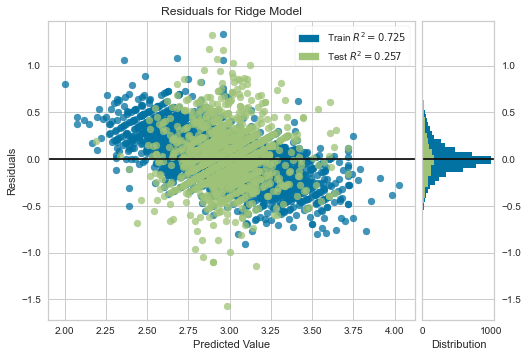

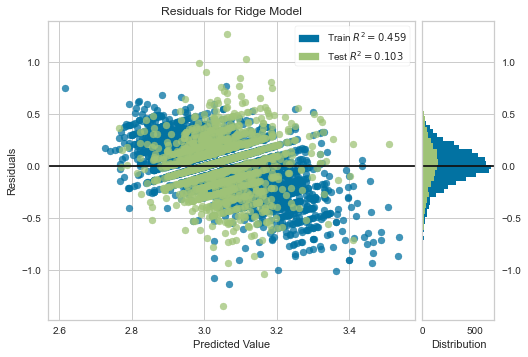

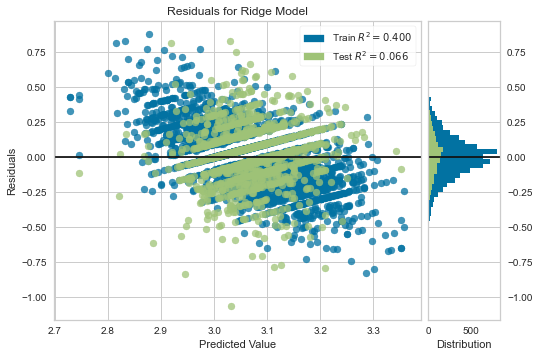

In [61]:
viz_V = residuals_plot(clf4, X_Vtrain, y_Vtrain, X_Vtest, y_Vtest)
viz_A = residuals_plot(clf5, X_Atrain, y_Atrain, X_Atest, y_Atest)
viz_D = residuals_plot(clf6, X_Dtrain, y_Dtrain, X_Dtest, y_Dtest)